# Clones, Installs, and Imports

In [1]:
!git clone https://github.com/zlisto/opinion_dynamics
import os
os.chdir("opinion_dynamics")


Cloning into 'opinion_dynamics'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 94 (delta 35), reused 34 (delta 7), pack-reused 0
Unpacking objects: 100% (94/94), done.


In [2]:
!pip install -r requirements.txt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 6.9 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [3]:
from scipy import integrate
from scipy.integrate import odeint
from scipy.sparse import coo_matrix,diags


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.opinion_data import *
from scripts.opinion_dynamics_gym import *
from scripts.opinion_visualization import *

pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({"axes.grid" : True})
plt.rcParams["figure.figsize"] = (18, 10)

# Simulator and Action Class and Helper Functions

## Action Class


In [240]:
class Action():
  def __init__(self, opinion, rate=1, targets=None):
    # Initializing the inputted features to the class
    self.opinion = opinion
    self.rate =  rate
    self.targets = targets
  def print(self):
    print(f"Agent opinion = {self.opinion:.3f}\nAgent rate = {self.rate:.3f}")
    print(f"Agent targets = {self.targets}")


## Discrete Opinion Simulator

In [241]:
class OpinionSimulator():
  def __init__(self, rate, shift_function, G, opinions_initial, max_steps = 1000):
    # Initializing the inputted features to the class
    self.A =  nx.adjacency_matrix(G)
    self.num_nodes = self.A.shape[0]
    self.rate = rate
    self.rate_total = np.sum(rate)
    self.shift = shift_function
    self.max_steps = max_steps
    self.prob = self.rate/self.rate_total
    # Counts the number of steps in a given simulation 
    self.step_counter = 0
    self.opinions_initial = opinions_initial.copy()
    self.opinions = opinions_initial.copy()
    assert len(self.opinions_initial)==self.num_nodes

  def step(self, action:Action):
    self.step_counter+=1
    mean_old = self.opinions.mean()
    if self.step_counter > self.max_steps:
      done = True
    else: 
      done = False
      
    ubot = np.random.uniform(low=0.0, high=1.0)
    pbot = action.rate/(action.rate + self.rate_total) #prob. bot tweets
    if ubot<=pbot:  #bot tweets
      node = 'agent'
      followers = action.targets
      if len(followers)>0:
        diff = action.opinion - self.opinions[followers] 
        #print(f"agent shift = {self.shift(diff)}")
        self.opinions[followers] = self.opinions[followers] + self.shift(diff)
        #clip opinions at 0 and 1
        self.opinions[followers[self.opinions[followers] < 0.0]] = 0.0
        self.opinions[followers[self.opinions[followers] > 1.0]] = 1.0
    else:  #human tweets
      node = np.random.choice(self.num_nodes, p = self.prob)
      followers = self.A[:,node].nonzero()[0]
      if len(followers)>0:
        diff = self.opinions[node] - self.opinions[followers] 
        self.opinions[followers] = self.opinions[followers] + self.shift(diff)
        #clip opinions at 0 and 1
        self.opinions[followers[self.opinions[followers] < 0.0]] = 0.0
        self.opinions[followers[self.opinions[followers] > 1.0]] = 1.0


    state = self.opinions.copy()
    reward = state.mean()-mean_old
    return state, node, reward, done

  def reset(self):
    self.step_counter = 0
    self.opinions = self.opinions_initial.copy()
    state = self.opinions_initial.copy()
    node = None
    done = False
    reward = 0
    return state, node, reward, done

## Continuous Time Opinion Simulator
 Use a Runge-Kutta step for $dt^4$ error.

In [242]:
class OpinionSimulatorContinuous():
  def __init__(self, rate, shift_function, G, opinions_initial, dt, max_steps = 1000):
    # Initializing the inputted features to the class
    self.A =  nx.adjacency_matrix(G)
    self.A = self.A.tocoo()
    self.num_nodes = self.A.shape[0]
    self.rate = rate
    self.dt = dt
    self.shift = shift_function
    self.max_steps = max_steps
    # Counts the number of steps in a given simulation 
    self.step_counter = 0
    self.opinions_initial = opinions_initial.copy()
    self.opinions = opinions_initial.copy()
    assert len(self.opinions_initial)==self.num_nodes
  
  def slope(self, opinions, action:Action):
    data = self.shift(opinions[self.A.row]- opinions[self.A.col])
    Shift_matrix = coo_matrix((data, (self.A.row, self.A.col)), shape=self.A.shape)
    Rate_matrix = diags(self.rate,0)

    D = Rate_matrix @ Shift_matrix
    Dxdt_no_agent = D.sum(axis = 0).A1  #contribution from following of node
    Dxdt = Dxdt_no_agent  
    
    #contribution from agent
    b = np.zeros(self.num_nodes)
    b[action.targets]= action.rate
    Dxdt_agent = b*self.shift(action.opinion-opinions)  #contribution from agent
    Dxdt += Dxdt_agent
    return Dxdt

  def step(self, action:Action):
    self.step_counter+=1
    mean_old = self.opinions.mean()
    if self.step_counter > self.max_steps:
      done = True
    else: 
      done = False
    #Runge-Kutta step
    state = self.opinions.copy()
    k1 = self.slope(state,action)
    y1 = state + self.dt/2 * k1
    k2 = self.slope(y1,action)
    y2 = state + self.dt/2 * k2
    k3 = self.slope(y2, action)
    y3 = state + self.dt*k3
    k4 = self.slope(y3, action)
    
    #Dxdt = self.slope(action)

    Dxdt_rk = 1/6*(k1 + 2*k2 + 2*k3 + k4)
    self.opinions+= Dxdt_rk*self.dt
    
    #clip opinions at 0 and 1
    self.opinions[self.opinions < 0.0] = 0.0
    self.opinions[self.opinions > 1.0] = 1.0


    reward = state.mean()-mean_old
    return state, done

  def reset(self):
    self.step_counter = 0
    self.opinions = self.opinions_initial.copy()
    state = self.opinions_initial.copy()
    node = None
    done = False
    reward = 0
    return state, done

## Continuous Time Adjoint Simulator

The adjoint simulator goes backwards in time from $t=T$ to $t=0$.

In [243]:
class AdjointSimulatorContinuous():
  def __init__(self, rate, dshift_function, G, P_final, dt, max_steps = 1000):
    # Initializing the inputted features to the class
    self.A =  nx.adjacency_matrix(G)
    self.A = self.A.tocoo()
    self.num_nodes = self.A.shape[0]
    self.rate = rate
    self.dt = dt
    self.dshift = dshift_function
    self.max_steps = max_steps
    # Counts the number of steps in a given simulation 
    self.step_counter = 0
    self.P_final = P_final.copy()
    self.P = P_final.copy()
    assert len(self.P_final)==self.num_nodes

  def step(self, action:Action, opinions):
    self.step_counter+=1
    if self.step_counter > self.max_steps:
      done = True
    else: 
      done = False

    ddata = self.dshift(opinions[self.A.row]- opinions[self.A.col])
    dShift_matrix = coo_matrix((ddata, (self.A.row, self.A.col)), shape = self.A.shape)
    Rate_matrix = diags(self.rate,0)

    dD = Rate_matrix @ dShift_matrix
    dd = dD.sum(axis=0).A1
    L = self.P*dd #contribution from following of node (its Leaders)
    F = dD @ self.P  #contribution from followers of node (its Followers)
    Dpdt = L-F

    #contribution from agent
    b = np.zeros(self.num_nodes)
    b[action.targets]= action.rate
    LA = self.P*b*self.dshift(action.opinion-opinions) #contribution from agent (its Leader Agent)
    Dpdt += LA
    self.P -= Dpdt*self.dt  #we are going backwards in time
    
    state = self.P.copy()
    return state, done

  def reset(self):
    self.step_counter = 0
    self.P = self.P_final.copy()
    state = self.P_final.copy()
    done = False
    return state, done

## Helper Functions

In [366]:
def load_brexit():
  path = '/content/drive/MyDrive/SocialNetworkAndOpinionDatasets/Brexit/'
  fname_opinion_rate = f"{path}Brexit_sample_01.csv"
  fname_adjlist  = f"{path}Brexit_sample.adjlist"

  df = pd.read_csv(fname_opinion_rate)
  G = nx.read_adjlist(fname_adjlist)
  V = [v for v in G.nodes()]
  df = df[df.user_id.astype(str).isin(V)]
  opinions_initial = df.opinion_tweet.array
  rate = df.rate.array

  mapping = {}
  mapping_rev = {}
  c=0
  for index, row in df.iterrows():
    c+=1
    mapping[str(row.user_id)] = c
    mapping_rev[c] = str(row.user_id)
  H = nx.relabel_nodes(G, mapping)
  return H, np.array(opinions_initial), np.array(rate) , mapping_rev

def load_giletsjaunes():
  path = '/content/drive/MyDrive/SocialNetworkAndOpinionDatasets/GiletsJaunes/'
  fname_opinion_rate = f"{path}GiletsJaunes_sample_02.csv"
  fname_adjlist  = f"{path}GiletsJaunes_sample_02.adjlist"

  df = pd.read_csv(fname_opinion_rate)
  df['user_id'] = df.user_id.astype(str)

  G = nx.read_adjlist(fname_adjlist)
  V = [v for v in G.nodes()]
  df = df[df.user_id.astype(str).isin(V)]
  opinions_initial = df.opinion_tweet.array
  rate = df.rate.array

  mapping = {}
  mapping_rev = {}
  c=0
  for index, row in df.iterrows():
    c+=1
    mapping[str(row.user_id)] = c
    mapping_rev[c] = str(row.user_id)
  H = nx.relabel_nodes(G, mapping)
  return H, np.array(opinions_initial), np.array(rate) , mapping_rev

#sign of agent's opinion above or below target
def pull_sign(i, iswitch):
  if i<iswitch:
    psign = -1
  else: 
    psign = 1
  return psign

def clip(x, xmin=0, xmax = 1):
  return min(xmax, max(x,xmin))

def plot_opinions_adjoint(opinions, agent_opinions, P, dt, reward = 0):
  nv = opinions.shape[1]
  nsteps = min(opinions.shape[0], len(agent_opinions))
  T = np.arange(0, nsteps*dt, dt)
  fig = plt.subplot(1,2,1)
  n = opinions.shape[1]
  for k in range(nv):
    plt.plot(T,opinions[:,k], label = f"{k}")
  plt.ylabel('Opinion')
  plt.xlabel('Time')
  plt.plot(T,agent_opinions[:], linewidth = 3, 
          color = 'red', label = 'Agent')
  plt.title(f"R(T) = {reward:.2f}")
  plt.legend()

  plt.subplot(1,2,2)
  for k in range(n):
    plt.plot(T,P[:,k], label = f"{k}")
  plt.ylabel('P')
  plt.xlabel('Time')
  plt.legend()
  #
  #plt.subplot(2,2,3)
  #nx.draw(G_agent,with_labels=True,node_size = 1000, width = 2)
  return fig

def plot_opinions(opinions, agent_opinions, dt, reward = 0, quantile_plot = False):
  nv = opinions.shape[1]  #number of nodes
  assert opinions.shape[0] == len(agent_opinions)
  nsteps = opinions.shape[0]
  T = np.arange(0, nsteps*dt, dt)
  fig = plt.subplot(1,1,1)
  if quantile_plot == True:
    print("quantile plot")
    Q05 = np.quantile(opinions,0.05,axis = 1)
    Q95 = np.quantile(opinions,0.95,axis = 1)
    Q50 = np.quantile(opinions,0.50,axis = 1)
    Q25 = np.quantile(opinions,0.25,axis = 1)
    Q75 = np.quantile(opinions,0.75,axis = 1)

    plt.plot(T,Q05,color = 'skyblue', linewidth = 1)
    plt.plot(T,Q95,color = 'skyblue', linewidth = 1)
    plt.fill_between(T, Q05, Q95,  color='skyblue', alpha=0.5)

    plt.plot(T,Q25,color = 'blue', linewidth = 1)
    plt.plot(T,Q75,color = 'blue', linewidth = 1)
    plt.fill_between(T, Q25, Q75, color='blue', alpha=0.4)
    plt.plot(T,Q50,color = 'darkblue', linewidth = 2)
  else:
    for k in range(nv):
      plt.plot(T,opinions, label = f"{k}")
  
  plt.ylabel('Opinion')
  plt.xlabel('Time')
  plt.plot(T,agent_opinions, linewidth = 3, 
          color = 'red', label = 'Agent')
  plt.title(f"R(T) = {reward:.2f}")
  plt.legend()
 
  return fig


# Opinion Shift and dShift Functions

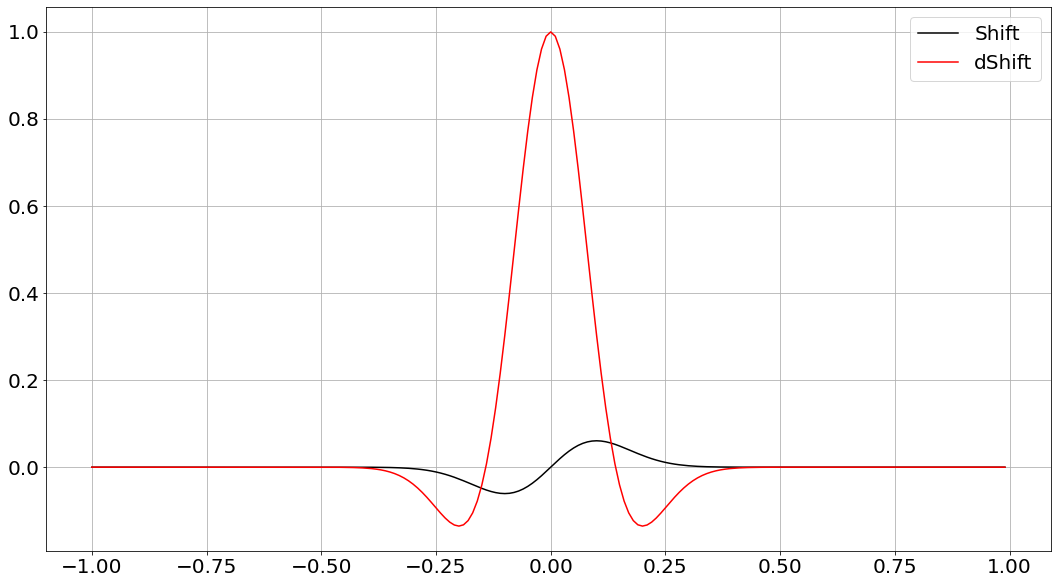

In [4]:
PEAK = 0.1
def hk_shift(shift):
  return shift*np.exp(-shift**2/2/PEAK **2)

def hk_dshift(shift):
  return (1-shift**2/2/PEAK**2)*np.exp(-shift**2/2/PEAK **2)

u = np.arange(-1,1,0.01)
plt.plot(u,hk_shift(u), 
         color = 'black', label = 'Shift')
plt.plot(u,hk_dshift(u), 
         color = 'red', label = 'dShift')
plt.legend()

# Load Simulator Dataset

## Toy networks

In [ ]:
# Toy networks
opinions_initial = np.array([1,0.0,]).astype(float)
G = nx.DiGraph()
#edges = [(0,1),(1,0), (0,2),(2,0),(1,2),(2,1)]
edges =[(0,1)]
for edge in edges:
  G.add_edge(edge[0],edge[1])


n = G.number_of_nodes()
rate = np.ones(n)  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 0.5  #time step [days]
P_final = np.ones(n)/n
max_steps = 60

## Brexit Network

In [13]:
G, opinions_initial, rate , mapping = load_brexit()
nv = G.number_of_nodes()
assert len(opinions_initial) == nv
assert len(rate) == nv

rate = rate/30  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 10/np.sum(rate)  #time step [days]
P_final = np.ones(nv)/nv
max_steps = np.round(7/dt)

print(f"Simulator will run for {max_steps} steps covering {dt*max_steps:.3f} days")
print(f"Network has {nv} nodes")
print(f"Mean user rate = {rate.mean():.2f} tweets/day")

Simulator will run for 7047.0 steps covering 7.000 days
Network has 1514 nodes
Mean user rate = 6.65 tweets/day


## Gilets Jaunes Network

In [5]:
G, opinions_initial, rate , mapping = load_brexit()
nv = G.number_of_nodes()
assert len(opinions_initial) == nv
assert len(rate) == nv

rate = rate/30  #tweet rate [tweets/day]
shift_function = hk_shift
dshift_function = hk_dshift
dt = 10/np.sum(rate)  #time step [days]
P_final = np.ones(nv)/nv
max_steps = np.round(7/dt)

print(f"Simulator will run for {max_steps} steps covering {dt*max_steps:.3f} days")
print(f"Network has {nv} nodes")
print(f"Mean user rate = {rate.mean():.2f} tweets/day")

Simulator will run for 7047.0 steps covering 7.000 days
Network has 1514 nodes
Mean user rate = 6.65 tweets/day


# Agent and Simulate

## Agent Targets, Rate

1) `targets` = array of indices of targets in network (not their user_ids)

2) `agent_rate` = tweet rate of agent

In [6]:
 #define agent parameters
targets = np.array([x for x in range(500,550)])
assert len(targets)<=nv
agent_rate = 20   

G_agent = G.copy()
for target in targets:
  G_agent.add_edge('agent',target)
if nv <=10:
  nx.draw(G_agent,with_labels=True,node_size = 10000, width = 2)



In [7]:
env = OpinionSimulatorContinuous(rate, shift_function, G, opinions_initial,dt, max_steps)
env_P = AdjointSimulatorContinuous(rate, dshift_function, G, P_final, dt, max_steps)

/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:38: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A =  nx.adjacency_matrix(G)
/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:109: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A =  nx.adjacency_matrix(G)


## Simulate Opinions and Adjoint 

Opinion simulated forward in time.

Adjoint simulated backwards in time.

/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:135: RuntimeWarning: overflow encountered in multiply
  L = self.P*dd #contribution from following of node (its Leaders)
/content/opinion_dynamics/scripts/opinion_dynamics_gym.py:142: RuntimeWarning: invalid value encountered in multiply
  LA = self.P*b*self.dshift(action.opinion-opinions) #contribution from agent (its Leader Agent)


quantile plot


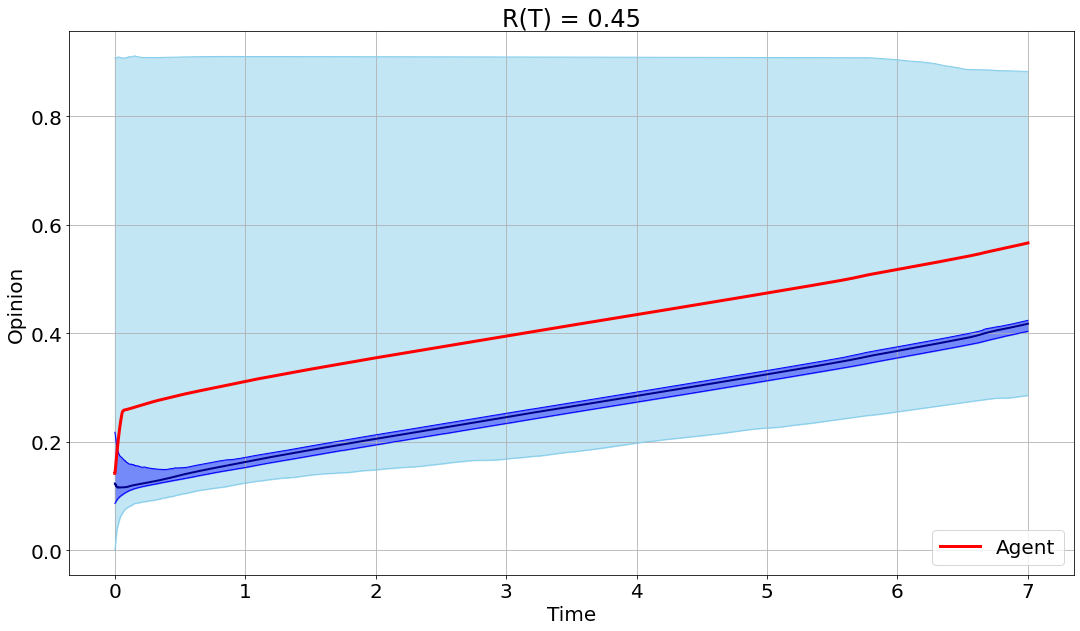

In [8]:
#%%time
iswitch = 0

  
opinions = []
agent_opinions = []
agent_rates = []

#############
i = 0
state, done = env.reset()
psign = pull_sign(i, iswitch)
agent_opinion = clip(state[targets].min() + PEAK*np.sqrt(2)*psign)
opinions.append(state)
agent_opinions.append(agent_opinion)

while not done:
  i+=1
  action = Action(agent_opinion, agent_rate, targets)
  state, done = env.step(action)
  psign = pull_sign(i, iswitch)
  agent_opinion = clip(state[targets].min() + PEAK*np.sqrt(2)*psign)
  agent_opinions.append(agent_opinion)
  agent_rates.append(agent_rate)
  opinions.append(state)

reward = state.mean()

opinions = np.array(opinions)
agent_opinions = np.array(agent_opinions)
#Adjoint
P = np.zeros(opinions.shape)
state, done = env_P.reset()
i = P.shape[0]-1
P[i,:] = state
while not done:
  i-=1
  agent_opinion = agent_opinions[i]
  agent_rate = agent_rates[i]
  opinion = opinions[i,:]
  action = Action(agent_opinion, agent_rate, targets)

  state, done = env_P.step(action, opinion)
  P[i,:] = state

plot_opinions(opinions, agent_opinions, dt, reward, quantile_plot = True)
#plot_opinions_adjoint(opinions, agent_opinions, P, dt, reward)

# Optimize Over Switching Time

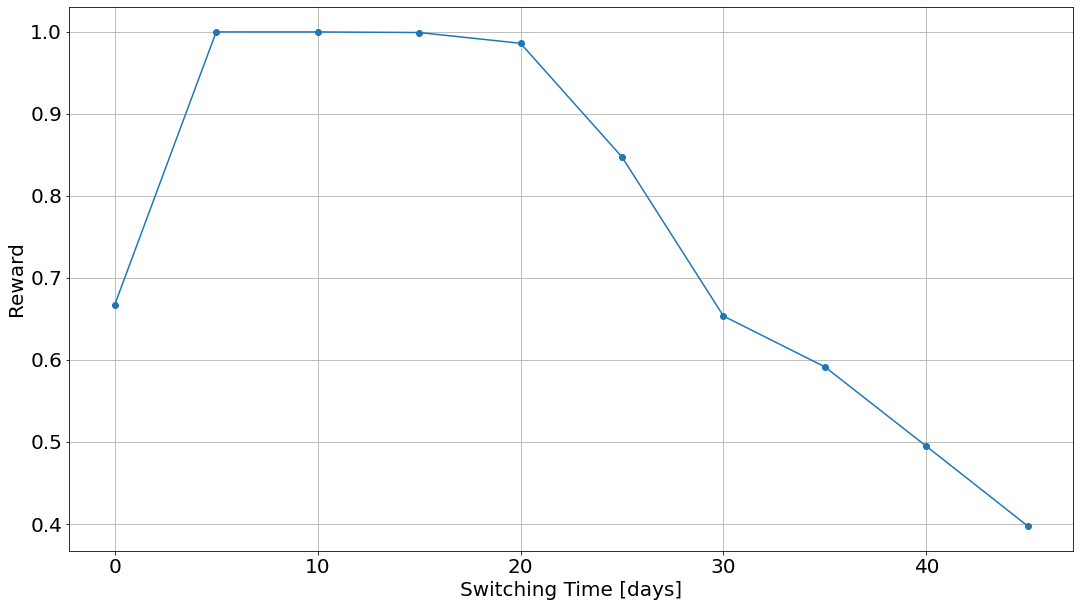

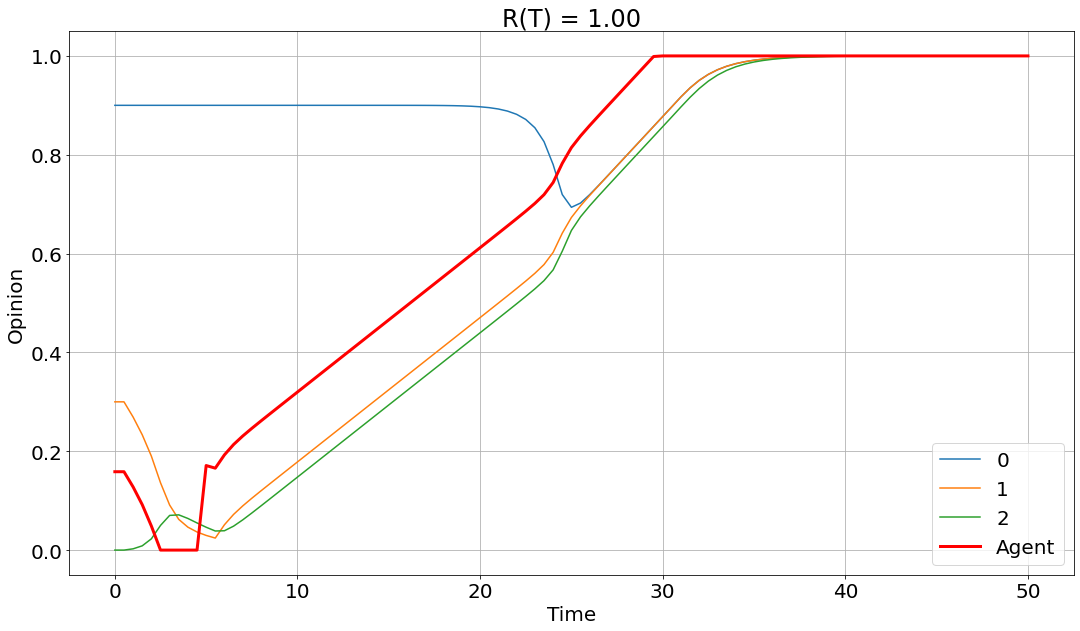

In [ ]:
iswitches = np.arange(0,max_steps, 10)
def bang_bang(env, agent_rate, targets, iswitches, VERBOSE = True ):
  rewards = np.zeros(iswitches.shape)
  reward_best = -np.inf
  agent_opinions_best = np.inf
  for cnt, iswitch in enumerate(iswitches):
    opinions = []
    i = 0
    state, done = env.reset()
    opinions.append(state)
    agent_opinions = []
    agent_rates = []

    while not done:
      i+=1
      if i<=iswitch:
        psign = -1
      else: psign = 1
      agent_opinion = state[targets].min()+PEAK*np.sqrt(2)*psign
      agent_opinion = min(1,max(0,agent_opinion))
      agent_opinions.append(agent_opinion)
      agent_rates.append(agent_rate)
      action = Action(agent_opinion, agent_rate, targets)
    
      state, done = env.step(action)
      opinions.append(state)

    opinions = np.array(opinions)
    reward = state.mean()
    rewards[cnt] = reward

    if iswitch%10==0 and VERBOSE: 
      print(f"iswitch = {iswitch}: Reward  = {reward:.2f}")

    if reward > reward_best:
      if VERBOSE:
        print(f"\ttswitch = {iswitch*env.dt:.3f}: Reward Best/New Reward = {reward_best:.2f}/{reward:.2f}")
      reward_best = reward
      iswitch_best = iswitch
      agent_opinions_best = agent_opinions
      agent_rate_best = agent_rate
      opinions_best = opinions
  return agent_opinions_best, opinions_best, rewards


agent_opinions_best, opinions_best, rewards = bang_bang(env, agent_rate, targets, iswitches, False )
reward_best = np.max(rewards)
plt.plot(iswitches*env.dt, rewards, marker = 'o')
plt.xlabel("Switching Time [days]")
plt.ylabel("Reward")
plt.show()

plot_opinions(opinions_best, agent_opinions_best, env.dt, reward_best)


# Image Agent Optimization

We add an image agent to the network followed by the agent.  The image agent runs the optimal opinion (agent_opinion +- $tau$).  We optimize over `agent_opinion[0]` and `tswitch`

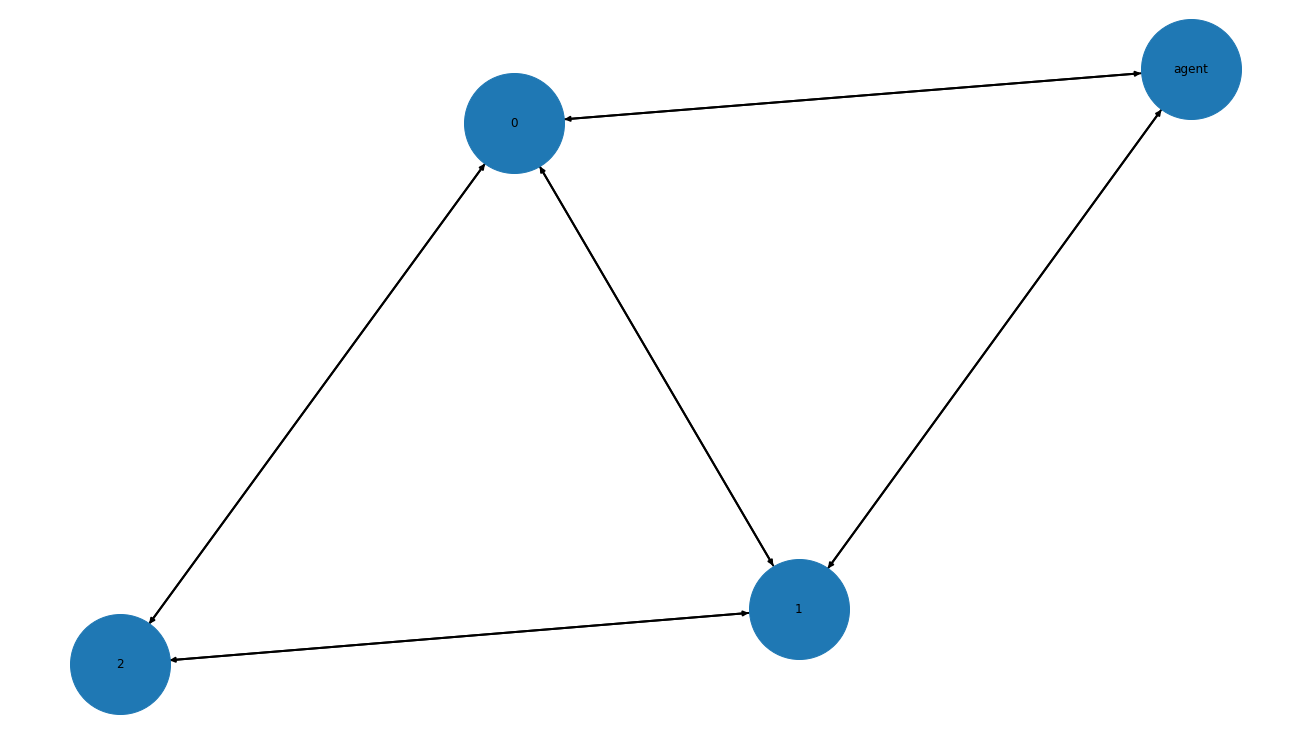

In [ ]:
#add agent to network
G_a = G.copy()
for target in targets:
  G_a.add_edge('agent',target)
  G_a.add_edge(target,'agent')  #listening
if n <=100:
  nx.draw(G_a,with_labels=True,node_size = 10000, width = 2)
  pass
n_a = G_a.number_of_nodes()
image_rate = 3
image_targets = n_a-1

In [ ]:
# pick tswitch, pick agent_opinion_0
u0s = np.arange(0, 1, 0.1)
iswitches0  = np.arange(0, max_steps, max_steps/10) #inital search
iswitches1 = np.arange(10, 11, 1)  #refined search

iswitches = iswitches0
Y = []  #(u0, tswitch, reward)
reward_best = -np.inf
for u0 in u0s:
  print(f"Agent initial opinion = {u0:.3f}")
  opinions_initial_a = np.append(opinions_initial, u0)
  rate_a = np.append(rate, agent_rate )
  assert len(opinions_initial_a)==n_a
  assert len(rate_a)==n_a

  #create environment for G_agent (network with agent as a human)
  env_a = OpinionSimulatorContinuous(rate_a, shift_function, G_a, opinions_initial_a, dt, max_steps)
  
  for cnt, iswitch in enumerate(iswitches):
    opinions = []
    image_opinions = []

    i = 0
    state, done = env_a.reset()
    if i<=iswitch:
      psign = -1
    else: 
      psign = 1
    #opinion of image agent is max above or below agent's opinion (state[-1])
    image_opinion = state[-1].min()+PEAK*np.sqrt(2)*psign
    
    opinions.append(state)
    image_opinions.append(image_opinion)

    while not done:
      i+=1
      #agent_rates_baseline.append(image_rate)
      action = Action(image_opinion, image_rate, image_targets)
    
      state, done = env_a.step(action)
      if i<=iswitch:
        psign = -1
      else: 
        psign = 1
      image_opinion = state[-1].min()+PEAK*np.sqrt(2)*psign

      opinions.append(state)
      image_opinions.append(image_opinion)

    opinions = np.array(opinions)
    image_opinions = np.array(image_opinions)
    reward = state[0:-1].mean()  #remove agent from state
    Y.append((u0, iswitch, reward))
    if reward> reward_best:
      print(f"{u0:.2f}, {iswitch}: new reward/reward_best = {reward:.4f}/{reward_best:.4f}")
      reward_best = reward
      opinions_best = opinions
      image_opinions_best = image_opinions #image agent
      agent_opinions_best = opinions_best[:,-1]  #actual agent
      



Agent initial opinion = 0.000


<ipython-input-53-438699317771>:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  self.A =  nx.adjacency_matrix(G)


0.00, 0.0: new reward/reward_best = 0.4586/-inf
Agent initial opinion = 0.100
Agent initial opinion = 0.200
0.20, 0.0: new reward/reward_best = 0.4683/0.4586
Agent initial opinion = 0.300
0.30, 0.0: new reward/reward_best = 0.4878/0.4683
Agent initial opinion = 0.400
0.40, 0.0: new reward/reward_best = 0.5010/0.4878
Agent initial opinion = 0.500
0.50, 0.0: new reward/reward_best = 0.5057/0.5010
Agent initial opinion = 0.600
Agent initial opinion = 0.700
Agent initial opinion = 0.800
Agent initial opinion = 0.900


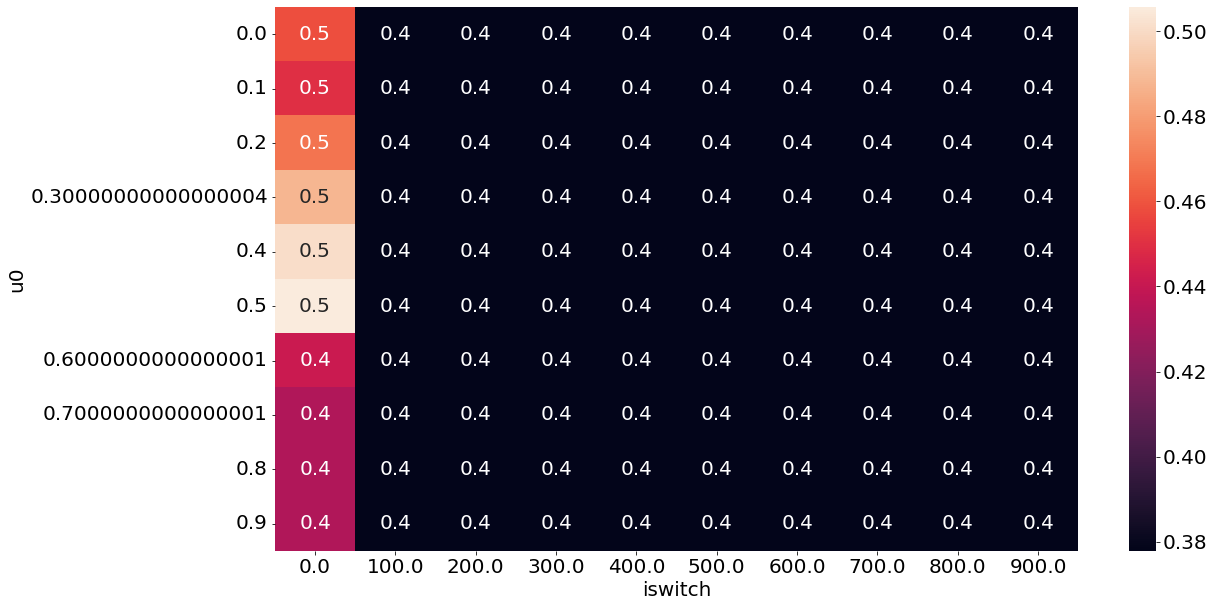

In [ ]:
df_image = pd.DataFrame(Y, columns=['u0','iswitch','reward'])
sns.heatmap(df_image.pivot("u0", "iswitch", "reward"),annot=True, fmt=".1f")

In [ ]:
opinions = []
i = 0
state, done = env.reset()
opinions.append(state)
while not done:
  i+=1
  agent_opinion = agent_opinions_best[i-1]
  #agent_opinion = min(1,max(0,agent_opinion))
  action = Action(agent_opinion, agent_rate, targets)
  state, done = env.step(action)
  opinions.append(state)

reward = state.mean()

opinions = np.array(opinions)

#plot_opinions(opinions, agent_opinions_best, env.dt, reward)
#plt.title("Agent Trained with Listening + Image Agent")
#plt.show()

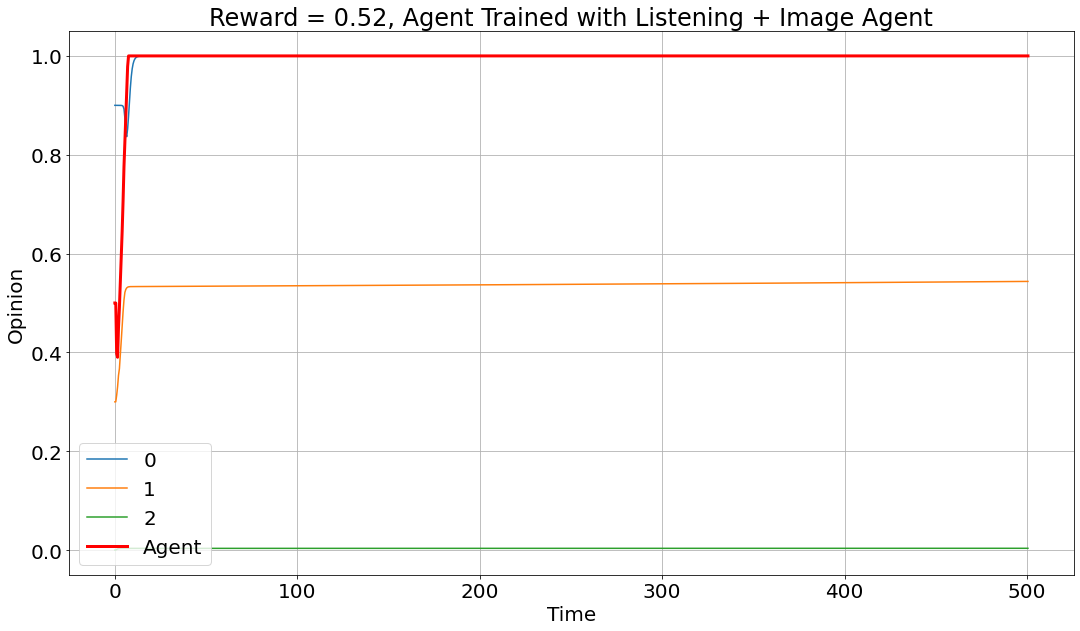

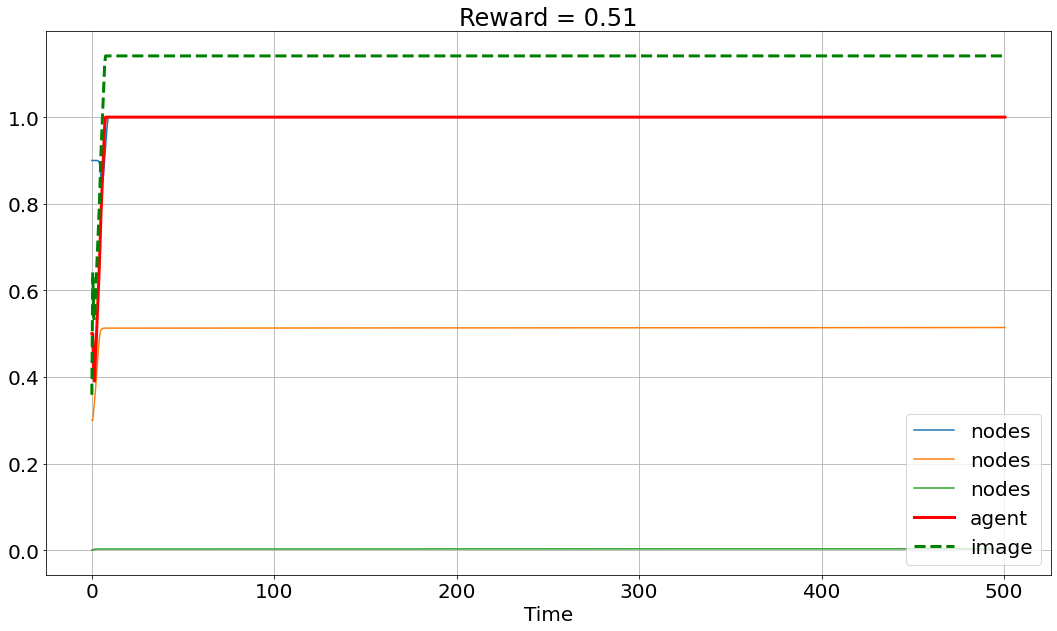

In [ ]:
plot_opinions(opinions, agent_opinions_best, env.dt, reward)
plt.title(f"Reward = {reward:.2f}, Agent Trained with Listening + Image Agent")
plt.show()

T = np.arange(0, env_a.dt*len(agent_opinions_best), env_a.dt)
plt.plot(T,opinions_best[:,0:-1], label = 'nodes')
plt.plot(T,agent_opinions_best, linewidth = 3, color = 'red', label = 'agent')
plt.plot(T,image_opinions_best, '--',linewidth = 3, color = 'green', label = 'image')
plt.legend()
plt.title(f"Reward = {reward_best:.2f}")
plt.xlabel("Time")
plt.show()

# Agent Rate Perturbation


Text(0, 0.5, 'Posting Rate')

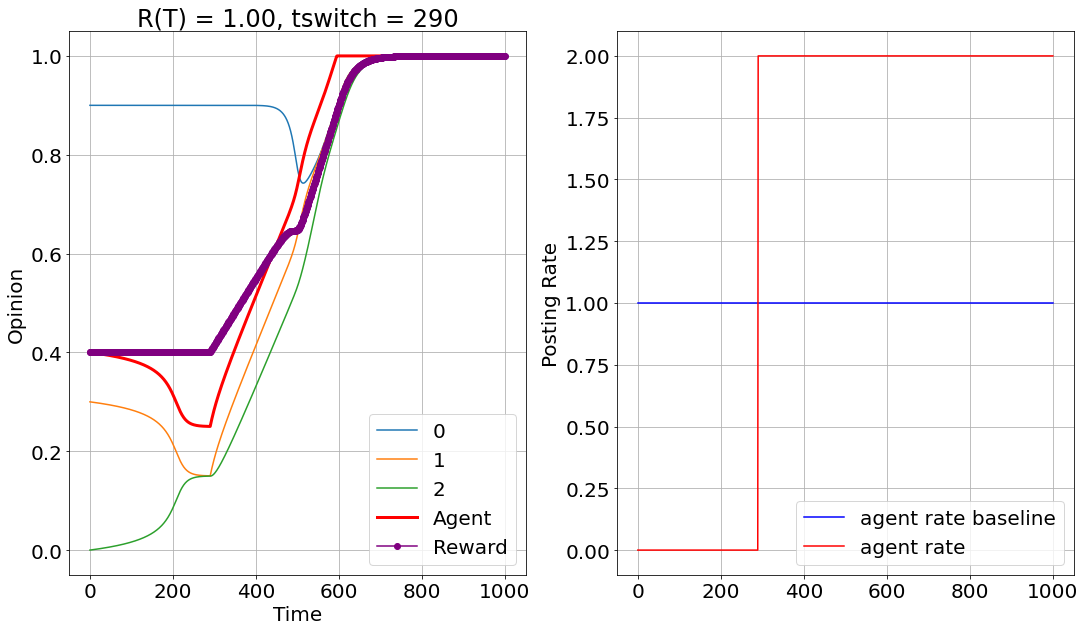

In [ ]:
tswitch = 290
opinions = []
rewards = []
i = 0
state, reward, done = env.reset()
opinions.append(state)
agent_opinions = []
agent_rates = []
rate_max = 1
while not done:
  i+=1
  agent_opinion = state[targets].min()+0.1
  agent_opinion = min(1,max(0,agent_opinion))

  if i<=tswitch:
    rate_perturb = -rate_max
  else:
    rate_perturb = rate_max

  action = Action(agent_opinion, agent_rate + rate_perturb, targets)
  
  #step in simulator
  state, reward, done = env.step(action)

  opinions.append(state)
  agent_opinions.append(agent_opinion)
  agent_rates.append(agent_rate + rate_perturb)

  rewards.append(state.mean())


opinions = np.array(opinions)



plt.subplot(1,2,1)
for k in range(n):
  plt.plot(opinions[:,k], label = f"{k}")
plt.ylabel('Opinion')
plt.xlabel('Time')
plt.plot(agent_opinions, linewidth = 3, 
         color = 'red', label = 'Agent')
plt.plot(rewards, marker = 'o', 
         color = 'purple', label = 'Reward')
plt.title(f"R(T) = {rewards[-1]:.2f}, tswitch = {tswitch:.0f}")
plt.legend()
plt.ylim([-0.05,1.05])
plt.subplot(1,2,2)
plt.plot(agent_rates_baseline, label = 'agent rate baseline', color = 'blue')
plt.plot(agent_rates, label = 'agent rate', color = 'red')
plt.legend()
plt.ylabel("Posting Rate")
#nx.draw(G,with_labels=True,node_size = 1000, width = 4)

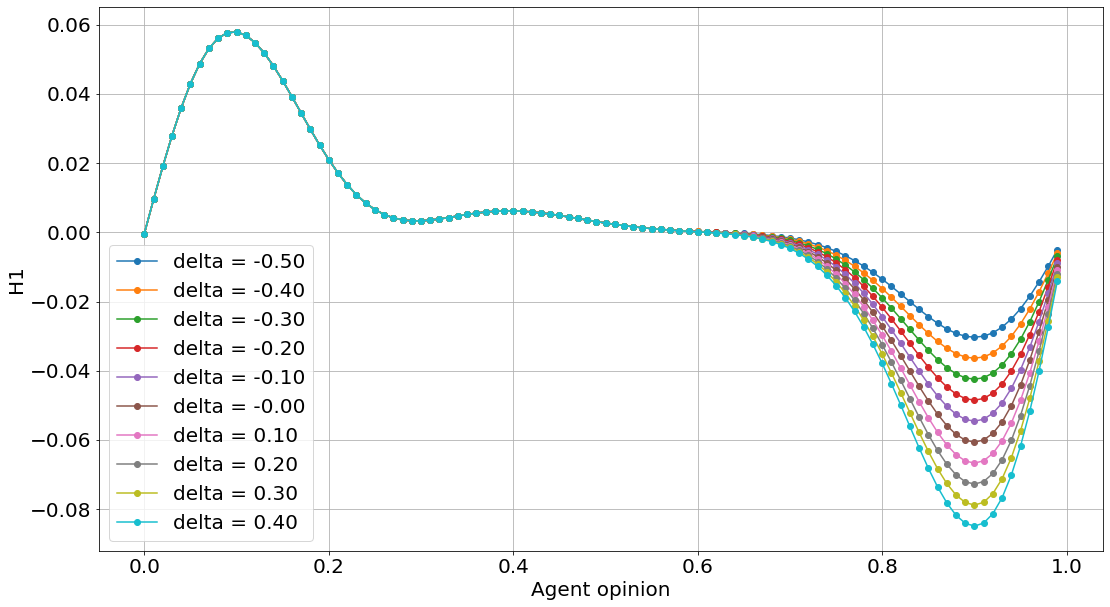

In [ ]:
u = np.arange(0,1, 0.01)
for delta in np.arange(-0.5,0.5,0.1):
  h = (1+delta)*hk_shift(u-1) + hk_shift(u-0) +  0.1*hk_shift(u-0.30)
  plt.plot(u,h, 'o-', label = f'delta = {delta:.2f}')
plt.legend()
plt.xlabel("Agent opinion")
plt.ylabel("H1")
plt.show()

# Twitter Datasets

Create a networkx graph object and save to adjlist file for networks:

1) `Brexit_sample_01` - Sample of 2000 nodes from the Brexit network from Hunter, Zaman 2021.

2) `GilesJaunes_sample_01` - 

## Brexit Sample 01

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [263]:
path = '/content/drive/MyDrive/SocialNetworkAndOpinionDatasets/Brexit/'

#Brexit sampled graph (only 2000 nodes out of 104,000)
df = pd.read_csv(f"{path}Brexit_sample_01.csv")
df.rename(columns={'Unnamed: 0': 'sim_id'}, inplace=True)
df['user_id'] = df.user_id.astype(str)
df = df[['sim_id','user_id','bot','rate','opinion_tweet', 'friend_names']]
df = df[~df.user_id.str.contains("agent")]  #remove agent rows
V = df.user_id.unique()
df
#df.to_csv(f"{path}Brexit_sample_01.csv", index = False)

sim_id     user_id  bot   rate  opinion_tweet  \
0          0   327083822    0  719.0       0.000000   
1          1      414153    0   24.0       0.149892   
2          2   837789068    0   53.0       0.087039   
3          3  2598188281    1  486.0       0.971542   
4          4   279706083    0  112.0       0.000000   
...      ...         ...  ...    ...            ...   
1995    1995  4705321903    0   16.0       0.000000   
1996    1996   105319506    0   18.0       0.094832   
1997    1997    11288432    0   31.0       0.078267   
1998    1998   333498071    0   75.0       0.000000   
1999    1999   318924938    0   10.0       0.170645   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
%%time
fname_adjlist  = f"{path}Brexit_sample.adjlist"
G = nx.DiGraph()
e = []
for index,row in df.iterrows():
  try:
    parents = [v for v in row.friend_names.split(",") if v in V ]
    for parent in parents:
      G.add_edge(parent, row.user_id)
  except: 
    print(f"Friend name: {row.friend_names}")
    e.append(row)
nv, ne  = G.number_of_nodes(), G.number_of_edges()
nx.write_adjlist(G, fname_adjlist)
G1 = nx.read_adjlist(fname_adjlist)
nv1, ne1  = G1.number_of_nodes(), G1.number_of_edges()

print(f"G has {nv} nodes, {ne} edges")
print(f"G1 has {nv1} nodes, {ne1} edges")

Friend name: nan
Friend name: nan
G has 1514 nodes, 8842 edges
G1 has 1514 nodes, 6448 edges
CPU times: user 36.5 s, sys: 3.12 s, total: 39.6 s
Wall time: 35.4 s


## Gilets Jaunes Sample 01

In [276]:
#GJ sampled graph (only 2000 nodes out of 30,000)
path = '/content/drive/MyDrive/SocialNetworkAndOpinionDatasets/GiletsJaunes/'
df = pd.read_csv(f"{path}GiletsJaunes_sample_02_no_agent.csv")
df['user_id'] = df.user_id.astype(str)
df = df[~df.user_id.str.contains("agent")]
df['sim_id'] = [x for x in range(len(df))]
df = df[['sim_id','user_id','bot','rate','opinion_tweet', 'friend_names']]
df['user_id'] = df.user_id.astype(str)
df.to_csv(f"{path}GiletsJaunes_sample_02.csv", index = False)


In [279]:
df = pd.read_csv(f"{path}GiletsJaunes_sample_02.csv")
df['user_id'] = df.user_id.astype(str)

V = df.user_id.unique()

df.tail()

,sim_id,user_id,bot,rate,opinion_tweet,friend_names
1995,1995,2419148433,1,19.0,0.718620,"1028668294751039488,578189188,1072496989009534979,3235859229,18721640,1283018743"
1996,1996,2297942773,0,15.0,0.522959,"1011302185,932933255258615809,66509519,2773565144,12786782,1353259730,1956909679,1429279021,982732105686896641,622863262,95229608,560462299,4063296063,229912552,335979100,1037175962880884741,2954948741,938391911987138560,2935010276,824592025303609344,1028261324629991424,805561738510925824,2176179939,1029107165427064838,716280630296907776,560377088,4219901475,271602424,821016379314814976,3543555915,824336155214827525,717406522930806784,388523472,520792073,977868734575628288,632958717,2869487498,560197363,376868280,856500044723359745,198246254,313841509,839938634967093251,804960455034867712,719254515548037121,1024741839797190656,4212006401,3373279888,860779676725379072,901117077125201920,3636892523,707908811470802944,120937651,184973125,1049050627022749696,310814746,322002182,64502626,2973569074,493400724,399607308,835174698623336448,49379219,359454688,67856446,160534877,978634478137565184,742093696540282880,1477222381,12418842,376465044,54825818,385600073,2918297386,808440877865717766,450667485,906602276525146113,2361250834,858683949299761152,509981951,910127605277495297,300314836,1380350618,2194423693,803196071556108288,863173089810665472,4905817683,3021369148,715943269654462464,250657766,818847510546546690,134187849,2188542098,353463122,556902767,716650590927978496,595382891,369006624,712216639052324864,4897361049,35022597,250323361,1243147873,112103858,2204263431,613419982,482878437,1600769100,472412809,197492504,151043323,455806353,380925855,57315555,56107736,927290354,311601642,47399805"
1997,1997,1048757528379707392,0,3.0,0.217563,"30266529,3580248555,1099028867178786822,1292292102,414120634,1068036310240305152,938139949710405633,829717519,562357936,3304499628,1013877380551774210,934399189,68972878,892943585703854080,131633337,863492594667589633,931150256934400000,822462665910063105,2468708726,2753220014,4828339398,162301746,4223251997"
1998,1998,2650827173,0,11.0,0.000000,"2914396899,1068143363306725377,1081940485487411201,321371482,854217206229499904,2716482522,1072123394836062209,1019905650745401345,3233716409,1924702003,87738447,415231233,802852196,2971966642,879703697596481536,753974664041533440,3156576852,919095188009701377,784636611183214592,947238380454150145,1064501612696268801,848000866640687104,295112173,192012830,3504007693,966479320779710464,153776534,967747216654905346,2293900897,284039382,977526649100165121,845345797415821313,937012241395781634,2617270398,827469927317635072,2687750085,735337219452506112,1127998578"
1999,1999,332222148,1,9.0,0.502163,"861134037213229056,716650590927978496,472852289,3354964647,1014802056069222400,91569130,92302750,957247977545981953,869305963630780418,14710574,155606403,2482185637,85286475,19976004,1353259730,908047632,35777570,3994873689,1006020644,84404216,287102687,17844275,276934698,233532563,3012235893,36026024,2290975766,18396319,3025757015,299871963,405336045,92849144,978184280,475704650,1415740381,3028247758,410175771,1920691543,251997775,133663801,1117869236,469248037,17364400,200386708,469808565,927290354,1875944024,584741992,8350912,105165371,471163803,316956459,78085410"


In [281]:
%%time
fname_adjlist  = f"{path}GiletsJaunes_sample_02.adjlist"
G = nx.DiGraph()
e = []
for index,row in df.iterrows():
  try:
    parents = [v for v in row.friend_names.split(",") if v in V ]
    for parent in parents:
      G.add_edge(parent, row.user_id)
  except: 
    print(f"Friend name: {row.friend_names}")
    e.append(row)
nv, ne  = G.number_of_nodes(), G.number_of_edges()
nx.write_adjlist(G, fname_adjlist)
G1 = nx.read_adjlist(fname_adjlist)
nv1, ne1  = G1.number_of_nodes(), G1.number_of_edges()

print(f"G has {nv} nodes, {ne} edges")
print(f"G1 has {nv1} nodes, {ne1} edges")

Friend name: nan
Friend name: nan
Friend name: nan
Friend name: nan
G has 1656 nodes, 12390 edges
G1 has 1656 nodes, 9346 edges
CPU times: user 17.3 s, sys: 1.03 s, total: 18.4 s
Wall time: 17.9 s
